<a href="https://colab.research.google.com/github/georgezefko/car-part-segmentation/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import glob

In [ ]:
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [ ]:
all_images_path = '/content/drive/MyDrive/final_set/signle_colors'
all_car_names = [img for img in glob.glob(all_images_path + "/*.jpg")]
all_car_names.sort() # ADD THIS LINE
all_cars = []
for img in all_car_names:
    n= cv2.imread(img)
    all_cars.append(n)
img =  np.array(all_cars)  

In [ ]:
#this fucntion preprocess fake imags
def fake_pre_process(fake):
  fi = fake
  f2 = fi.permute(0,2,3,1)
  f2 = f2*255
  f2 = f2.detach().cpu()
  f2 = np.array(f2)
  f2 = f2.astype(np.uint8)
  f2 = f2.astype('float32')
  f2 = scale_images(f2, (299,299,3))
  f2 = preprocess_input(f2)
  return f2

def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model,images2):
	# calculate activations
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu_real - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma_real.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma_real + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
 # Calculate activations, mu, sigma for the real images
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
images = img.astype('float32')
images = scale_images(images, (299,299,3))
images = preprocess_input(images)
act_real = model.predict(images)
mu_real = act_real.mean(axis=0) 
sigma_real  =  cov(act_real, rowvar=False)

In [ ]:
# Root directory for dataset
#path ="/content/drive/My Drive/Deloitte_data/carseg_data/only_masks"
path = '/content/drive/My Drive/final_set'
# Number of workers for dataloader
workers = 4

# Batch size during training
# batch_size = 128
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr_gen = 0.0002
lr_dis = 0.00002 #0.00005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
dataset = dset.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [ ]:


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


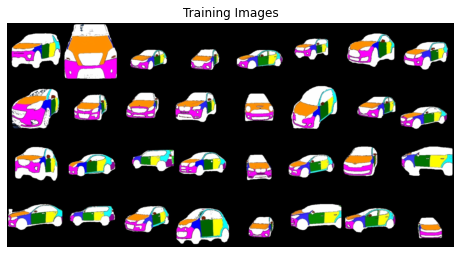

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [ ]:
# 

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
      return self.main(input)

In [ ]:

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

 
    def forward(self, input):
      return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [ ]:
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)
optimizerD = optim.Adam(netD.parameters(), lr=lr_dis, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_gen, betas=(beta1, 0.999))

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()


In [ ]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0


In [ ]:
netG.train()
netD.train()
print(netG)
print(netD)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [ ]:
model_path = '/content/drive/Mydrive/DC_results'

Starting Training Loop...
[0/1000][0/8]	Loss_D: 1.5533	Loss_G: 1.0348	D(x): 0.5693	D(G(z)): 0.6184 / 0.3591


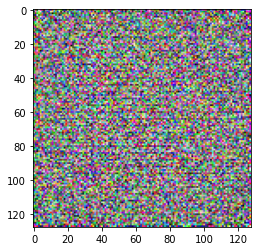

[1/1000][0/8]	Loss_D: 3.9420	Loss_G: 0.4762	D(x): 0.7919	D(G(z)): 0.9731 / 0.6276
[2/1000][0/8]	Loss_D: 3.3821	Loss_G: 1.3603	D(x): 0.7313	D(G(z)): 0.9494 / 0.2679
[3/1000][0/8]	Loss_D: 2.8123	Loss_G: 2.1371	D(x): 0.6445	D(G(z)): 0.8971 / 0.1213
[4/1000][0/8]	Loss_D: 2.0550	Loss_G: 2.6958	D(x): 0.7212	D(G(z)): 0.8112 / 0.0689
[5/1000][0/8]	Loss_D: 1.7049	Loss_G: 2.8660	D(x): 0.6668	D(G(z)): 0.7160 / 0.0580
[6/1000][0/8]	Loss_D: 1.5908	Loss_G: 3.0449	D(x): 0.6918	D(G(z)): 0.6860 / 0.0499
[7/1000][0/8]	Loss_D: 1.4707	Loss_G: 2.9630	D(x): 0.7160	D(G(z)): 0.6395 / 0.0586
[8/1000][0/8]	Loss_D: 1.9553	Loss_G: 2.7831	D(x): 0.6206	D(G(z)): 0.7164 / 0.0734
[9/1000][0/8]	Loss_D: 2.4270	Loss_G: 2.5422	D(x): 0.5637	D(G(z)): 0.7924 / 0.0879
[10/1000][0/8]	Loss_D: 2.6885	Loss_G: 2.5866	D(x): 0.4328	D(G(z)): 0.7418 / 0.0804
[11/1000][0/8]	Loss_D: 2.3725	Loss_G: 2.5856	D(x): 0.4359	D(G(z)): 0.7438 / 0.0766
[12/1000][0/8]	Loss_D: 1.7969	Loss_G: 2.6792	D(x): 0.5155	D(G(z)): 0.6644 / 0.0690
[13/1000][0/8

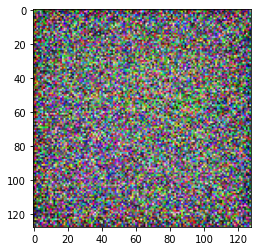

[63/1000][0/8]	Loss_D: 0.1565	Loss_G: 3.2580	D(x): 0.9553	D(G(z)): 0.1044 / 0.0389
[64/1000][0/8]	Loss_D: 0.0985	Loss_G: 3.6955	D(x): 0.9574	D(G(z)): 0.0532 / 0.0250
[65/1000][0/8]	Loss_D: 0.1011	Loss_G: 3.7939	D(x): 0.9329	D(G(z)): 0.0301 / 0.0226
[66/1000][0/8]	Loss_D: 0.0937	Loss_G: 3.5194	D(x): 0.9707	D(G(z)): 0.0617 / 0.0298
[67/1000][0/8]	Loss_D: 0.0804	Loss_G: 4.0542	D(x): 0.9570	D(G(z)): 0.0351 / 0.0177
[68/1000][0/8]	Loss_D: 0.0755	Loss_G: 3.8177	D(x): 0.9642	D(G(z)): 0.0380 / 0.0222
[69/1000][0/8]	Loss_D: 0.0874	Loss_G: 3.9113	D(x): 0.9533	D(G(z)): 0.0384 / 0.0203
[70/1000][0/8]	Loss_D: 0.1005	Loss_G: 3.7884	D(x): 0.9499	D(G(z)): 0.0469 / 0.0229
[71/1000][0/8]	Loss_D: 0.0876	Loss_G: 4.1703	D(x): 0.9392	D(G(z)): 0.0218 / 0.0155
[72/1000][0/8]	Loss_D: 0.0445	Loss_G: 4.2714	D(x): 0.9738	D(G(z)): 0.0175 / 0.0141
[73/1000][0/8]	Loss_D: 0.0629	Loss_G: 3.9573	D(x): 0.9619	D(G(z)): 0.0216 / 0.0192
[74/1000][0/8]	Loss_D: 0.0991	Loss_G: 3.5513	D(x): 0.9661	D(G(z)): 0.0620 / 0.0289
[75/

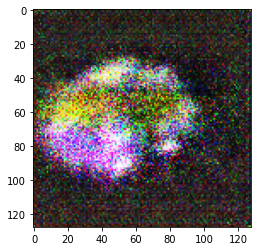

[126/1000][0/8]	Loss_D: 0.2783	Loss_G: 2.5891	D(x): 0.9015	D(G(z)): 0.1140 / 0.0751
[127/1000][0/8]	Loss_D: 0.1205	Loss_G: 3.6861	D(x): 0.9372	D(G(z)): 0.0380 / 0.0252
[128/1000][0/8]	Loss_D: 0.1862	Loss_G: 3.3798	D(x): 0.9423	D(G(z)): 0.1075 / 0.0342
[129/1000][0/8]	Loss_D: 0.1705	Loss_G: 3.5172	D(x): 0.9387	D(G(z)): 0.0981 / 0.0297
[130/1000][0/8]	Loss_D: 0.2541	Loss_G: 3.2430	D(x): 0.9019	D(G(z)): 0.1279 / 0.0391
[131/1000][0/8]	Loss_D: 0.1602	Loss_G: 3.2810	D(x): 0.9010	D(G(z)): 0.0453 / 0.0378
[132/1000][0/8]	Loss_D: 0.4506	Loss_G: 3.8180	D(x): 0.6986	D(G(z)): 0.0134 / 0.0220
[133/1000][0/8]	Loss_D: 0.3611	Loss_G: 3.1286	D(x): 0.8544	D(G(z)): 0.1571 / 0.0438
[134/1000][0/8]	Loss_D: 0.1875	Loss_G: 3.5381	D(x): 0.9300	D(G(z)): 0.1012 / 0.0291
[135/1000][0/8]	Loss_D: 0.1671	Loss_G: 3.3862	D(x): 0.9468	D(G(z)): 0.1039 / 0.0339
[136/1000][0/8]	Loss_D: 0.0723	Loss_G: 4.0335	D(x): 0.9717	D(G(z)): 0.0419 / 0.0177
[137/1000][0/8]	Loss_D: 0.1003	Loss_G: 4.1500	D(x): 0.9576	D(G(z)): 0.0543 /

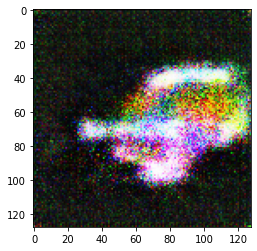

[188/1000][0/8]	Loss_D: 0.0505	Loss_G: 4.4779	D(x): 0.9767	D(G(z)): 0.0247 / 0.0114
[189/1000][0/8]	Loss_D: 0.0494	Loss_G: 4.4033	D(x): 0.9875	D(G(z)): 0.0358 / 0.0123
[190/1000][0/8]	Loss_D: 0.0664	Loss_G: 3.8746	D(x): 0.9704	D(G(z)): 0.0343 / 0.0208
[191/1000][0/8]	Loss_D: 0.0524	Loss_G: 4.4204	D(x): 0.9655	D(G(z)): 0.0135 / 0.0120
[192/1000][0/8]	Loss_D: 0.0801	Loss_G: 3.9053	D(x): 0.9628	D(G(z)): 0.0267 / 0.0201
[193/1000][0/8]	Loss_D: 0.0494	Loss_G: 4.8824	D(x): 0.9926	D(G(z)): 0.0411 / 0.0076
[194/1000][0/8]	Loss_D: 0.1490	Loss_G: 3.3539	D(x): 0.8997	D(G(z)): 0.0234 / 0.0350
[195/1000][0/8]	Loss_D: 0.0481	Loss_G: 4.2370	D(x): 0.9883	D(G(z)): 0.0352 / 0.0145
[196/1000][0/8]	Loss_D: 0.0761	Loss_G: 3.9145	D(x): 0.9582	D(G(z)): 0.0288 / 0.0200
[197/1000][0/8]	Loss_D: 0.1949	Loss_G: 3.5251	D(x): 0.9145	D(G(z)): 0.0616 / 0.0295
[198/1000][0/8]	Loss_D: 0.4881	Loss_G: 6.6187	D(x): 0.9486	D(G(z)): 0.3479 / 0.0013
[199/1000][0/8]	Loss_D: 0.7284	Loss_G: 8.7921	D(x): 0.9512	D(G(z)): 0.4882 /

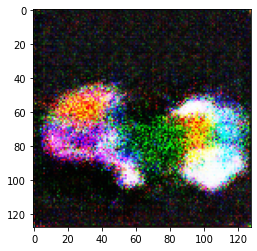

[251/1000][0/8]	Loss_D: 0.0319	Loss_G: 5.1804	D(x): 0.9780	D(G(z)): 0.0093 / 0.0056
[252/1000][0/8]	Loss_D: 0.0370	Loss_G: 4.2020	D(x): 0.9919	D(G(z)): 0.0284 / 0.0150
[253/1000][0/8]	Loss_D: 0.0394	Loss_G: 4.3192	D(x): 0.9902	D(G(z)): 0.0290 / 0.0134
[254/1000][0/8]	Loss_D: 0.0469	Loss_G: 5.0630	D(x): 0.9724	D(G(z)): 0.0168 / 0.0064
[255/1000][0/8]	Loss_D: 0.0367	Loss_G: 5.7645	D(x): 0.9760	D(G(z)): 0.0117 / 0.0031
[256/1000][0/8]	Loss_D: 0.0886	Loss_G: 3.7508	D(x): 0.9394	D(G(z)): 0.0180 / 0.0235
[257/1000][0/8]	Loss_D: 0.0933	Loss_G: 4.2070	D(x): 0.9761	D(G(z)): 0.0652 / 0.0149
[258/1000][0/8]	Loss_D: 0.0699	Loss_G: 4.0614	D(x): 0.9533	D(G(z)): 0.0128 / 0.0172
[259/1000][0/8]	Loss_D: 0.0339	Loss_G: 4.7234	D(x): 0.9878	D(G(z)): 0.0211 / 0.0089
[260/1000][0/8]	Loss_D: 0.0551	Loss_G: 5.2160	D(x): 0.9751	D(G(z)): 0.0197 / 0.0054
[261/1000][0/8]	Loss_D: 0.0699	Loss_G: 3.9434	D(x): 0.9712	D(G(z)): 0.0375 / 0.0194
[262/1000][0/8]	Loss_D: 0.1324	Loss_G: 4.8081	D(x): 0.9661	D(G(z)): 0.0909 /

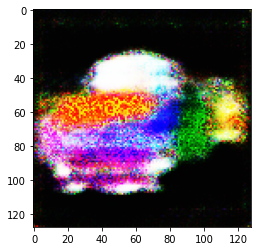

[313/1000][0/8]	Loss_D: 0.5933	Loss_G: 2.6146	D(x): 0.8236	D(G(z)): 0.3106 / 0.0852
[314/1000][0/8]	Loss_D: 0.4888	Loss_G: 1.5139	D(x): 0.7544	D(G(z)): 0.1763 / 0.2335
[315/1000][0/8]	Loss_D: 0.5313	Loss_G: 1.7958	D(x): 0.7550	D(G(z)): 0.2003 / 0.1902
[316/1000][0/8]	Loss_D: 0.6361	Loss_G: 1.6499	D(x): 0.6454	D(G(z)): 0.1504 / 0.2191
[317/1000][0/8]	Loss_D: 0.6786	Loss_G: 1.6492	D(x): 0.7756	D(G(z)): 0.3302 / 0.2158
[318/1000][0/8]	Loss_D: 0.5319	Loss_G: 1.7153	D(x): 0.7257	D(G(z)): 0.1687 / 0.2011
[319/1000][0/8]	Loss_D: 0.5067	Loss_G: 2.0288	D(x): 0.7519	D(G(z)): 0.1895 / 0.1466
[320/1000][0/8]	Loss_D: 0.6868	Loss_G: 2.9691	D(x): 0.9122	D(G(z)): 0.4308 / 0.0588
[321/1000][0/8]	Loss_D: 0.3126	Loss_G: 3.1992	D(x): 0.8590	D(G(z)): 0.1393 / 0.0503
[322/1000][0/8]	Loss_D: 0.7280	Loss_G: 1.3228	D(x): 0.5427	D(G(z)): 0.0809 / 0.2973
[323/1000][0/8]	Loss_D: 0.5744	Loss_G: 1.5242	D(x): 0.7475	D(G(z)): 0.2056 / 0.2491
[324/1000][0/8]	Loss_D: 0.4556	Loss_G: 1.7743	D(x): 0.8228	D(G(z)): 0.2182 /

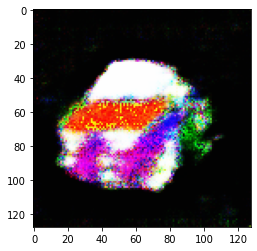

[376/1000][0/8]	Loss_D: 0.2915	Loss_G: 2.2371	D(x): 0.8322	D(G(z)): 0.0967 / 0.1279
[377/1000][0/8]	Loss_D: 0.3720	Loss_G: 2.7909	D(x): 0.9061	D(G(z)): 0.2289 / 0.0742
[378/1000][0/8]	Loss_D: 0.3096	Loss_G: 3.1822	D(x): 0.9023	D(G(z)): 0.1766 / 0.0487
[379/1000][0/8]	Loss_D: 0.3845	Loss_G: 3.1431	D(x): 0.9233	D(G(z)): 0.2503 / 0.0526
[380/1000][0/8]	Loss_D: 0.3061	Loss_G: 2.4873	D(x): 0.8725	D(G(z)): 0.1499 / 0.0973
[381/1000][0/8]	Loss_D: 0.3380	Loss_G: 2.0713	D(x): 0.9131	D(G(z)): 0.2055 / 0.1580
[382/1000][0/8]	Loss_D: 0.4053	Loss_G: 2.8460	D(x): 0.8998	D(G(z)): 0.2446 / 0.0697
[383/1000][0/8]	Loss_D: 0.2868	Loss_G: 2.4692	D(x): 0.8862	D(G(z)): 0.1461 / 0.1017
[384/1000][0/8]	Loss_D: 0.3175	Loss_G: 2.6109	D(x): 0.8898	D(G(z)): 0.1771 / 0.0805
[385/1000][0/8]	Loss_D: 0.7684	Loss_G: 3.2608	D(x): 0.9566	D(G(z)): 0.4865 / 0.0457
[386/1000][0/8]	Loss_D: 0.4106	Loss_G: 2.3267	D(x): 0.8292	D(G(z)): 0.1768 / 0.1191
[387/1000][0/8]	Loss_D: 0.4692	Loss_G: 1.2265	D(x): 0.6616	D(G(z)): 0.0368 /

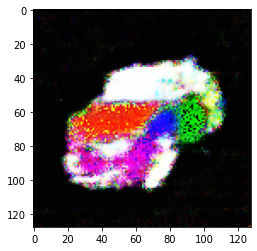

[438/1000][0/8]	Loss_D: 0.2515	Loss_G: 2.1712	D(x): 0.8526	D(G(z)): 0.0812 / 0.1331
[439/1000][0/8]	Loss_D: 0.2362	Loss_G: 3.3394	D(x): 0.8967	D(G(z)): 0.1132 / 0.0445
[440/1000][0/8]	Loss_D: 0.6256	Loss_G: 4.0032	D(x): 0.9875	D(G(z)): 0.4092 / 0.0237
[441/1000][0/8]	Loss_D: 0.3285	Loss_G: 3.6195	D(x): 0.9733	D(G(z)): 0.2505 / 0.0304
[442/1000][0/8]	Loss_D: 0.1681	Loss_G: 3.1798	D(x): 0.8764	D(G(z)): 0.0330 / 0.0570
[443/1000][0/8]	Loss_D: 0.2722	Loss_G: 3.8117	D(x): 0.9437	D(G(z)): 0.1831 / 0.0285
[444/1000][0/8]	Loss_D: 0.1676	Loss_G: 3.1926	D(x): 0.9308	D(G(z)): 0.0879 / 0.0511
[445/1000][0/8]	Loss_D: 0.2022	Loss_G: 3.3074	D(x): 0.9088	D(G(z)): 0.0970 / 0.0465
[446/1000][0/8]	Loss_D: 0.3930	Loss_G: 3.6393	D(x): 0.9682	D(G(z)): 0.2865 / 0.0346
[447/1000][0/8]	Loss_D: 0.2465	Loss_G: 3.7132	D(x): 0.9530	D(G(z)): 0.1743 / 0.0295
[448/1000][0/8]	Loss_D: 0.1931	Loss_G: 2.9276	D(x): 0.8929	D(G(z)): 0.0725 / 0.0731
[449/1000][0/8]	Loss_D: 0.1642	Loss_G: 3.2238	D(x): 0.9296	D(G(z)): 0.0825 /

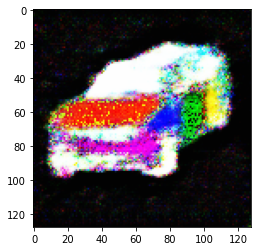

[501/1000][0/8]	Loss_D: 0.1854	Loss_G: 3.2151	D(x): 0.9764	D(G(z)): 0.1373 / 0.0576
[502/1000][0/8]	Loss_D: 0.1810	Loss_G: 3.2299	D(x): 0.9549	D(G(z)): 0.1207 / 0.0536
[503/1000][0/8]	Loss_D: 0.1314	Loss_G: 3.3523	D(x): 0.9603	D(G(z)): 0.0830 / 0.0460
[504/1000][0/8]	Loss_D: 0.1120	Loss_G: 3.1421	D(x): 0.9592	D(G(z)): 0.0672 / 0.0492
[505/1000][0/8]	Loss_D: 0.1766	Loss_G: 2.6362	D(x): 0.8715	D(G(z)): 0.0341 / 0.0941
[506/1000][0/8]	Loss_D: 0.2731	Loss_G: 3.7788	D(x): 0.9725	D(G(z)): 0.1955 / 0.0365
[507/1000][0/8]	Loss_D: 0.1814	Loss_G: 3.1628	D(x): 0.9144	D(G(z)): 0.0758 / 0.0560
[508/1000][0/8]	Loss_D: 0.1001	Loss_G: 3.7651	D(x): 0.9632	D(G(z)): 0.0585 / 0.0359
[509/1000][0/8]	Loss_D: 0.1866	Loss_G: 4.4321	D(x): 0.9690	D(G(z)): 0.1335 / 0.0139
[510/1000][0/8]	Loss_D: 0.1061	Loss_G: 3.1279	D(x): 0.9623	D(G(z)): 0.0642 / 0.0580
[511/1000][0/8]	Loss_D: 0.1193	Loss_G: 3.2941	D(x): 0.9785	D(G(z)): 0.0882 / 0.0550
[512/1000][0/8]	Loss_D: 1.0085	Loss_G: 2.8151	D(x): 0.3984	D(G(z)): 0.0035 /

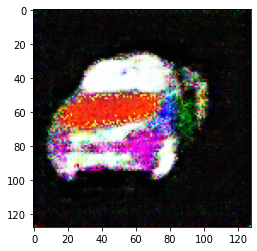

[563/1000][0/8]	Loss_D: 0.1179	Loss_G: 3.8837	D(x): 0.9739	D(G(z)): 0.0847 / 0.0265
[564/1000][0/8]	Loss_D: 0.1445	Loss_G: 4.7924	D(x): 0.9811	D(G(z)): 0.1114 / 0.0111
[565/1000][0/8]	Loss_D: 0.0954	Loss_G: 5.3538	D(x): 0.9173	D(G(z)): 0.0069 / 0.0066
[566/1000][0/8]	Loss_D: 0.1275	Loss_G: 3.8445	D(x): 0.9081	D(G(z)): 0.0238 / 0.0272
[567/1000][0/8]	Loss_D: 0.0807	Loss_G: 4.1962	D(x): 0.9588	D(G(z)): 0.0368 / 0.0215
[568/1000][0/8]	Loss_D: 0.0873	Loss_G: 3.6708	D(x): 0.9509	D(G(z)): 0.0354 / 0.0344
[569/1000][0/8]	Loss_D: 0.0955	Loss_G: 3.5995	D(x): 0.9286	D(G(z)): 0.0201 / 0.0363
[570/1000][0/8]	Loss_D: 0.0872	Loss_G: 3.8514	D(x): 0.9683	D(G(z)): 0.0520 / 0.0316
[571/1000][0/8]	Loss_D: 0.1508	Loss_G: 3.6219	D(x): 0.9917	D(G(z)): 0.1253 / 0.0361
[572/1000][0/8]	Loss_D: 0.1281	Loss_G: 4.1445	D(x): 0.9780	D(G(z)): 0.0982 / 0.0188
[573/1000][0/8]	Loss_D: 0.2179	Loss_G: 3.5929	D(x): 0.8239	D(G(z)): 0.0177 / 0.0397
[574/1000][0/8]	Loss_D: 0.3456	Loss_G: 4.4557	D(x): 0.9907	D(G(z)): 0.2488 /

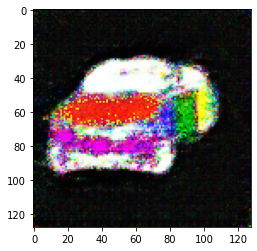

[626/1000][0/8]	Loss_D: 0.0452	Loss_G: 4.6356	D(x): 0.9794	D(G(z)): 0.0236 / 0.0135
[627/1000][0/8]	Loss_D: 0.1214	Loss_G: 4.5416	D(x): 0.9767	D(G(z)): 0.0900 / 0.0131
[628/1000][0/8]	Loss_D: 0.0668	Loss_G: 4.0947	D(x): 0.9665	D(G(z)): 0.0318 / 0.0211
[629/1000][0/8]	Loss_D: 0.0944	Loss_G: 5.0139	D(x): 0.9861	D(G(z)): 0.0724 / 0.0099
[630/1000][0/8]	Loss_D: 0.0839	Loss_G: 2.8829	D(x): 0.9383	D(G(z)): 0.0188 / 0.0727
[631/1000][0/8]	Loss_D: 0.5124	Loss_G: 0.8806	D(x): 0.6287	D(G(z)): 0.0010 / 0.4874
[632/1000][0/8]	Loss_D: 1.1707	Loss_G: 1.0961	D(x): 0.4756	D(G(z)): 0.1161 / 0.4682
[633/1000][0/8]	Loss_D: 1.3939	Loss_G: 4.5051	D(x): 0.9765	D(G(z)): 0.6685 / 0.0190
[634/1000][0/8]	Loss_D: 0.2826	Loss_G: 3.0962	D(x): 0.9471	D(G(z)): 0.1951 / 0.0522
[635/1000][0/8]	Loss_D: 0.2937	Loss_G: 2.1578	D(x): 0.7944	D(G(z)): 0.0518 / 0.1470
[636/1000][0/8]	Loss_D: 0.4897	Loss_G: 3.0232	D(x): 0.9777	D(G(z)): 0.3498 / 0.0600
[637/1000][0/8]	Loss_D: 0.1823	Loss_G: 2.7204	D(x): 0.9465	D(G(z)): 0.1160 /

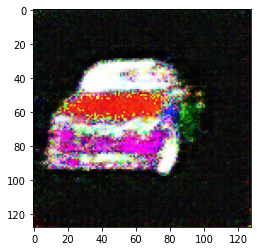

[688/1000][0/8]	Loss_D: 0.0361	Loss_G: 4.4514	D(x): 0.9879	D(G(z)): 0.0235 / 0.0160
[689/1000][0/8]	Loss_D: 0.6140	Loss_G: 2.1982	D(x): 0.5936	D(G(z)): 0.0007 / 0.3148
[690/1000][0/8]	Loss_D: 2.3325	Loss_G: 3.3346	D(x): 0.9851	D(G(z)): 0.7885 / 0.1373
[691/1000][0/8]	Loss_D: 0.8585	Loss_G: 3.5344	D(x): 0.9619	D(G(z)): 0.5056 / 0.0448
[692/1000][0/8]	Loss_D: 0.1893	Loss_G: 3.2290	D(x): 0.8671	D(G(z)): 0.0385 / 0.0548
[693/1000][0/8]	Loss_D: 0.3250	Loss_G: 2.9564	D(x): 0.9682	D(G(z)): 0.2237 / 0.0659
[694/1000][0/8]	Loss_D: 0.0869	Loss_G: 4.0070	D(x): 0.9688	D(G(z)): 0.0528 / 0.0232
[695/1000][0/8]	Loss_D: 0.1817	Loss_G: 2.6249	D(x): 0.8851	D(G(z)): 0.0554 / 0.0907
[696/1000][0/8]	Loss_D: 0.1067	Loss_G: 3.5558	D(x): 0.9288	D(G(z)): 0.0313 / 0.0355
[697/1000][0/8]	Loss_D: 0.0725	Loss_G: 3.8857	D(x): 0.9609	D(G(z)): 0.0316 / 0.0270
[698/1000][0/8]	Loss_D: 0.0705	Loss_G: 4.4591	D(x): 0.9549	D(G(z)): 0.0234 / 0.0168
[699/1000][0/8]	Loss_D: 0.0803	Loss_G: 3.2740	D(x): 0.9677	D(G(z)): 0.0455 /

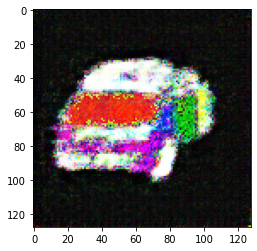

[751/1000][0/8]	Loss_D: 0.0215	Loss_G: 5.1849	D(x): 0.9876	D(G(z)): 0.0090 / 0.0082
[752/1000][0/8]	Loss_D: 0.0163	Loss_G: 5.1740	D(x): 0.9945	D(G(z)): 0.0107 / 0.0082
[753/1000][0/8]	Loss_D: 0.0466	Loss_G: 4.0738	D(x): 0.9650	D(G(z)): 0.0105 / 0.0229
[754/1000][0/8]	Loss_D: 0.0465	Loss_G: 4.0695	D(x): 0.9889	D(G(z)): 0.0341 / 0.0217
[755/1000][0/8]	Loss_D: 0.0316	Loss_G: 4.6058	D(x): 0.9869	D(G(z)): 0.0179 / 0.0156
[756/1000][0/8]	Loss_D: 0.0423	Loss_G: 4.5495	D(x): 0.9903	D(G(z)): 0.0315 / 0.0140
[757/1000][0/8]	Loss_D: 0.0338	Loss_G: 5.8654	D(x): 0.9698	D(G(z)): 0.0025 / 0.0041
[758/1000][0/8]	Loss_D: 0.1276	Loss_G: 4.8062	D(x): 0.9961	D(G(z)): 0.1098 / 0.0105
[759/1000][0/8]	Loss_D: 0.0354	Loss_G: 4.2510	D(x): 0.9898	D(G(z)): 0.0246 / 0.0217
[760/1000][0/8]	Loss_D: 0.0726	Loss_G: 4.3101	D(x): 0.9369	D(G(z)): 0.0060 / 0.0236
[761/1000][0/8]	Loss_D: 0.0229	Loss_G: 5.2446	D(x): 0.9927	D(G(z)): 0.0152 / 0.0088
[762/1000][0/8]	Loss_D: 0.0319	Loss_G: 4.0684	D(x): 0.9979	D(G(z)): 0.0288 /

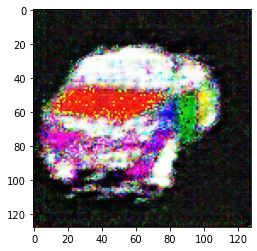

[813/1000][0/8]	Loss_D: 0.0719	Loss_G: 3.8963	D(x): 0.9634	D(G(z)): 0.0334 / 0.0257
[814/1000][0/8]	Loss_D: 0.1003	Loss_G: 4.2347	D(x): 0.9873	D(G(z)): 0.0802 / 0.0191
[815/1000][0/8]	Loss_D: 0.1117	Loss_G: 3.4221	D(x): 0.9403	D(G(z)): 0.0470 / 0.0420
[816/1000][0/8]	Loss_D: 0.0943	Loss_G: 4.2055	D(x): 0.9831	D(G(z)): 0.0726 / 0.0192
[817/1000][0/8]	Loss_D: 0.0974	Loss_G: 4.5829	D(x): 0.9931	D(G(z)): 0.0824 / 0.0140
[818/1000][0/8]	Loss_D: 0.0370	Loss_G: 4.3382	D(x): 0.9810	D(G(z)): 0.0175 / 0.0187
[819/1000][0/8]	Loss_D: 0.0668	Loss_G: 4.2932	D(x): 0.9893	D(G(z)): 0.0528 / 0.0193
[820/1000][0/8]	Loss_D: 0.0215	Loss_G: 4.9036	D(x): 0.9891	D(G(z)): 0.0105 / 0.0101
[821/1000][0/8]	Loss_D: 0.0353	Loss_G: 4.5796	D(x): 0.9847	D(G(z)): 0.0195 / 0.0142
[822/1000][0/8]	Loss_D: 0.0877	Loss_G: 4.1504	D(x): 0.9236	D(G(z)): 0.0073 / 0.0236
[823/1000][0/8]	Loss_D: 0.0375	Loss_G: 4.4496	D(x): 0.9895	D(G(z)): 0.0263 / 0.0163
[824/1000][0/8]	Loss_D: 0.0305	Loss_G: 5.1164	D(x): 0.9791	D(G(z)): 0.0092 /

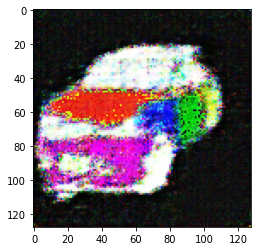

[876/1000][0/8]	Loss_D: 0.0311	Loss_G: 4.6401	D(x): 0.9954	D(G(z)): 0.0256 / 0.0156
[877/1000][0/8]	Loss_D: 0.0182	Loss_G: 5.4963	D(x): 0.9890	D(G(z)): 0.0071 / 0.0057
[878/1000][0/8]	Loss_D: 0.0288	Loss_G: 4.9526	D(x): 0.9971	D(G(z)): 0.0249 / 0.0115
[879/1000][0/8]	Loss_D: 0.0186	Loss_G: 4.9637	D(x): 0.9958	D(G(z)): 0.0142 / 0.0102
[880/1000][0/8]	Loss_D: 0.0133	Loss_G: 5.8836	D(x): 0.9927	D(G(z)): 0.0059 / 0.0055
[881/1000][0/8]	Loss_D: 0.0235	Loss_G: 5.6354	D(x): 0.9801	D(G(z)): 0.0034 / 0.0053
[882/1000][0/8]	Loss_D: 0.0455	Loss_G: 4.7380	D(x): 0.9983	D(G(z)): 0.0421 / 0.0111
[883/1000][0/8]	Loss_D: 0.0112	Loss_G: 5.8234	D(x): 0.9929	D(G(z)): 0.0041 / 0.0042
[884/1000][0/8]	Loss_D: 0.0138	Loss_G: 5.8181	D(x): 0.9935	D(G(z)): 0.0072 / 0.0048
[885/1000][0/8]	Loss_D: 0.0173	Loss_G: 4.9738	D(x): 0.9960	D(G(z)): 0.0131 / 0.0107
[886/1000][0/8]	Loss_D: 0.0325	Loss_G: 4.6309	D(x): 0.9779	D(G(z)): 0.0095 / 0.0150
[887/1000][0/8]	Loss_D: 0.0114	Loss_G: 6.0559	D(x): 0.9916	D(G(z)): 0.0030 /

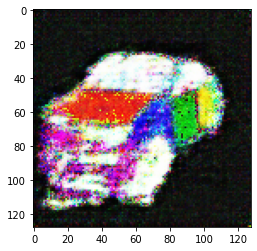

[938/1000][0/8]	Loss_D: 0.0185	Loss_G: 5.7402	D(x): 0.9878	D(G(z)): 0.0061 / 0.0051
[939/1000][0/8]	Loss_D: 0.0386	Loss_G: 4.9277	D(x): 0.9934	D(G(z)): 0.0307 / 0.0131
[940/1000][0/8]	Loss_D: 0.0222	Loss_G: 5.0562	D(x): 0.9885	D(G(z)): 0.0105 / 0.0106
[941/1000][0/8]	Loss_D: 0.0291	Loss_G: 4.8705	D(x): 0.9888	D(G(z)): 0.0173 / 0.0110
[942/1000][0/8]	Loss_D: 0.0148	Loss_G: 5.1961	D(x): 0.9930	D(G(z)): 0.0078 / 0.0087
[943/1000][0/8]	Loss_D: 0.0125	Loss_G: 5.6006	D(x): 0.9930	D(G(z)): 0.0054 / 0.0057
[944/1000][0/8]	Loss_D: 0.0286	Loss_G: 5.0307	D(x): 0.9906	D(G(z)): 0.0186 / 0.0104
[945/1000][0/8]	Loss_D: 0.0160	Loss_G: 4.9321	D(x): 0.9957	D(G(z)): 0.0116 / 0.0104
[946/1000][0/8]	Loss_D: 0.0232	Loss_G: 5.0799	D(x): 0.9965	D(G(z)): 0.0193 / 0.0095
[947/1000][0/8]	Loss_D: 0.0136	Loss_G: 5.4309	D(x): 0.9975	D(G(z)): 0.0110 / 0.0067
[948/1000][0/8]	Loss_D: 0.0098	Loss_G: 5.2787	D(x): 0.9977	D(G(z)): 0.0074 / 0.0081
[949/1000][0/8]	Loss_D: 0.0203	Loss_G: 5.0066	D(x): 0.9934	D(G(z)): 0.0136 /

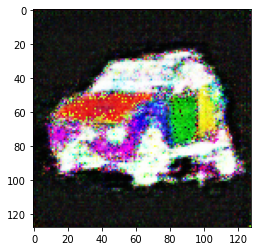

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    #for data,_ in dataloader:
    for i, data in enumerate(dataloader, 0):    

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        fakes = fake_pre_process(fake)
        fid_new = []
        fakes = netG(fixed_noise).detach().cpu()
        fakes = fake_pre_process(fakes)
        fid = calculate_fid(model,fakes)
        fid_new.append(fid)
        fid = sum(fid_new)/len(fid_new) 
        fid_s.append(fid)  
        if fid<max:
            max = fid
            torch.save(netG.state_dict(), model_path+'model_1or_bs4_'+str(round(max,2))+'.pth') 



        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img = transforms.ToPILImage(mode=None)(fake[0])
                plt.imshow(img)
                plt.show()

            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


  






      

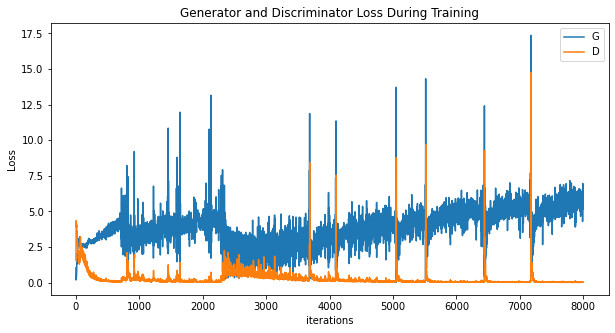

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

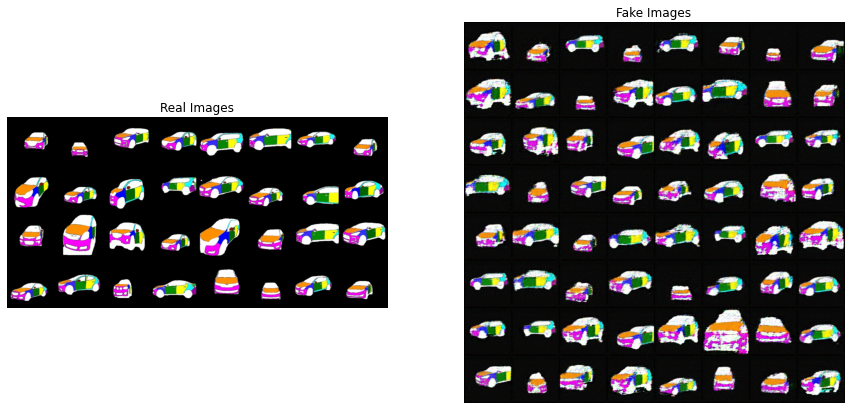

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()